In [1]:
#import required libraries 
%matplotlib inline
import os 
import numpy as np 
import geopandas as gpd 
import rasterio 
from rasterio.enums import Resampling
from rasterio.plot import show 
import matplotlib.pyplot as plt
import shutil
import xarray as xr
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from datacube.testutils.io import rio_slurp_xarray
from odc.algo import xr_reproject
import earthpy.plot as ep
import seaborn as sn
from glob import glob 
import gdal
sn.set()
sn.set_theme(color_codes=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#Reading all raster layers as one stacked file and get the mean and s.d of it 
data_dir = '..//Real_world_examples/LCCSlayer/coherence' # Or sys.argv[1]
file_list = glob(os.path.join(data_dir, '*.tif'))

def read_file(file):
    with rasterio.open(file) as src:
        return(src.read(1))

# Read all data as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]
# Perform averaging
array_out1 = np.median(array_list, axis=0)
array_out2 = np.std(array_list, axis=0)

# Get metadata from one of the input files
with rasterio.open(file_list[0]) as src:
    meta = src.meta
    
#updating the metadata

meta.update(dtype=rasterio.float32)

# Write output file
with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/median.tif', 'w', **meta) as dst:
    dst.write(array_out1.astype(rasterio.float32), 1)
with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/standard_dev.tif', 'w', **meta) as dst:
    dst.write(array_out2.astype(rasterio.float32), 1)

In [3]:
#Reading the stacked coherence layer 
coherence_median = xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/median.tif')
coherence_median.shape

(1, 965, 832)

In [10]:
# Read sampling points from shapefile
pts = gpd.read_file('..//Real_world_examples/LCCSlayer/coherence/samples_250m_landuse.shp')

In [11]:
pts = pts[['XGeometry', 'YGeometry', 'Value', 'Land_Cover','geometry']]

In [12]:
pts.index = range(len(pts))

In [13]:
pts

,XGeometry,YGeometry,Value,Land_Cover,geometry
0,151.838928,-24.915437,17,Natural Terrestrial Vegetated: Woody Closed (>...,POINT (151.83893 -24.91544)
1,151.819501,-24.920239,24,Natural Terrestrial Vegetated: Herbaceous Open...,POINT (151.81950 -24.92024)
2,151.824447,-24.919550,24,Natural Terrestrial Vegetated: Herbaceous Open...,POINT (151.82445 -24.91955)
3,151.829422,-24.919021,18,Natural Terrestrial Vegetated: Woody Open (40 ...,POINT (151.82942 -24.91902)
4,151.838485,-24.917380,23,Natural Terrestrial Vegetated: Herbaceous Open...,POINT (151.83848 -24.91738)
...,...,...,...,...,...
114363,150.390731,-28.799205,18,Natural Terrestrial Vegetated: Woody Open (40 ...,POINT (150.39073 -28.79920)
114364,150.396980,-28.795945,25,Natural Terrestrial Vegetated: Herbaceous Spar...,POINT (150.39698 -28.79594)
114365,150.401951,-28.793741,24,Natural Terrestrial Vegetated: Herbaceous Open...,POINT (150.40195 -28.79374)
114366,150.406337,-28.792577,11,Cultivated Terrestrial Vegetated: Herbaceous O...,POINT (150.40634 -28.79258)


In [14]:
#Rename the columns in the LCCS table 
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Open (15 to 40 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Open (40 to 65 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Scattered (1 to 4 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Sparse (4 to 15 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Closed (> 65 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)

pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Closed (> 65 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Open (15 to 40 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Open (40 to 65 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Scattered (1 to 4 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Sparse (4 to 15 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)

pts["Land_Cover"].replace({"Water: (Water) Non-perennial (1 to 3 months)":"Water Non-perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Perennial (> 9 months)":"Water Perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Tidal area":"Water Tidal"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Non-perennial (4 to 6 months)":"Water Non-perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Non-perennial (7 to 9 months)":"Water Non-perennial"}, inplace=True)

pts["Land_Cover"].replace({"Natural Surface: Very sparsely vegetated":"Natural Surface"}, inplace=True)
pts["Land_Cover"].replace({"Natural Surface: Sparsely vegetated":"Natural Surface"}, inplace=True)
pts["Land_Cover"].replace({"Natural Surface: Bare areas, unvegetated":"Natural Surface"}, inplace=True)

pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Sparse (4 to 15 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Scattered (1 to 4 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Open (40 to 65 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Open (15 to 40 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Closed (> 65 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)

pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Sparse (4 to 15 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Scattered (1 to 4 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Open (40 to 65 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Open (15 to 40 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Closed (> 65 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)

In [24]:
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated(Woody)":"Natural Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated(Herbaceous)":"Natural Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated(Herbaceous)":"Cultivated Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated(Woody)":"Cultivated Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Water Non-perennial":"Water","Water Perennial":"Water"}, inplace=True)

In [25]:
pts

,XGeometry,YGeometry,Value,Land_Cover,geometry,Median of Coherence,Standard Deviation of Coherence
0,151.838928,-24.915437,17,Natural Vegetation,POINT (151.83893 -24.91544),0.551345,0.276006
1,151.819501,-24.920239,24,Natural Vegetation,POINT (151.81950 -24.92024),0.598180,0.303803
2,151.824447,-24.919550,24,Natural Vegetation,POINT (151.82445 -24.91955),0.520061,0.296454
3,151.829422,-24.919021,18,Natural Vegetation,POINT (151.82942 -24.91902),0.580508,0.255528
4,151.838485,-24.917380,23,Natural Vegetation,POINT (151.83848 -24.91738),0.551345,0.276006
...,...,...,...,...,...,...,...
114363,150.390731,-28.799205,18,Natural Vegetation,POINT (150.39073 -28.79920),0.489972,0.116282
114364,150.396980,-28.795945,25,Natural Vegetation,POINT (150.39698 -28.79594),0.834070,0.170552
114365,150.401951,-28.793741,24,Natural Vegetation,POINT (150.40195 -28.79374),0.975108,0.141859
114366,150.406337,-28.792577,11,Cultivated Vegetation,POINT (150.40634 -28.79258),0.984849,0.169747


In [26]:
coords = [(x,y) for x, y in zip(pts.XGeometry, pts.YGeometry)]

In [27]:
# Open the coherence mean raster file and store metadata
src_median = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/median.tif')

In [28]:
# Sample the mean layer at every point location and store values in DataFrame
pts['Median of Coherence'] = [x for x in src_median.sample(coords)]
pts['Median of Coherence'] = pts.apply(lambda x: x['Median of Coherence'][0], axis=1)

In [29]:
# Open the coherence SD raster file and store metadata
src_SD = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/standard_dev.tif')

In [30]:
# Sample the SD layer at every point location and store values in DataFrame
pts['Standard Deviation of Coherence'] = [x for x in src_SD.sample(coords)]
pts['Standard Deviation of Coherence'] = pts.apply(lambda x: x['Standard Deviation of Coherence'][0], axis=1)

In [ ]:
#Get the geometry of the points 
geometry = [Point(xy) for xy in zip(pts.LON, pts.LAT)]
crs = {'init': 'epsg:4326'} 
samplepoints = GeoDataFrame(pts, crs=crs, geometry=geometry)

In [ ]:
AOI = '..//Real_world_examples/LCCSlayer/coherence/AOI_Assessment.shp'

In [ ]:
outline = gpd.read_file(AOI).to_crs('EPSG:4326')
outline

In [ ]:
Zone_points = gpd.clip(samplepoints, outline)

In [43]:
#pts_random_50pc = pts.sample(frac=0.5, replace=True, random_state=1)

In [45]:
#pts_selected = pts[5000:10000]

In [46]:
#pts_selected = pts_selected.rename(columns={'Coh_mean':'Mean of Coherence','Coh_SD':'Standad Deviation of Coherence'})

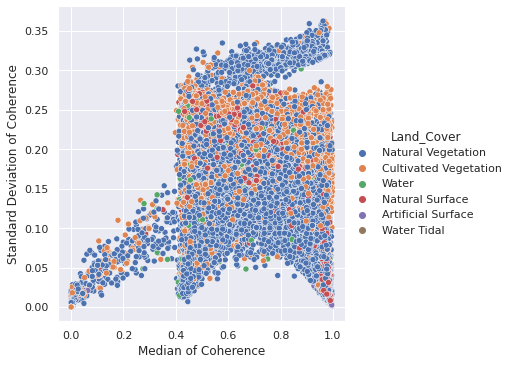

In [48]:
sn.relplot(x="Median of Coherence", y="Standard Deviation of Coherence", hue="Land_Cover",sizes=(10,150), data=pts);

In [37]:
# raster = gdal.Open(r'..//Real_world_examples/LCCSlayer/coherence/stack.tif')
# bands = raster.RasterCount

# for band in range(1, bands+1):
#     data = raster.GetRasterBand(band).ReadAsArray().astype('float')
#     mean = np.mean(data[data != 0]) #calculate mean without value 0
#     print("Band %s: Mean = %s" % (band, round(mean, 2)))

In [96]:
raster = gdal.Open(r'..//Real_world_examples/LCCSlayer/coherence/standard_dev.tif')
bands = raster.RasterCount

for band in range(1, bands+1):
    data = raster.GetRasterBand(band).ReadAsArray().astype('float')
    mean = np.mean(data[data != 0]) #calculate mean without value 0
    print("Band %s: Mean = %s" % (band, round(mean, 2)))

Band 1: Mean = 0.16


In [ ]:
#Add raster files as bands 
data_dir = '..//Real_world_examples/LCCSlayer/coherence' # Or sys.argv[1]
file_list = glob(os.path.join(data_dir, '*.tif'))

with rasterio.open(file_list[0]) as src0:
    meta = src0.meta
#update meta to reflect the number of raster files
meta.update(count = len(file_list))
#Read each layer and write it to the stack
with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/stack.tif','w',**meta) as dst:
    for id, layer in enumerate(file_list,start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id,src1.read(1))

In [ ]:
#Reading the stacked coherence layer 
coherence = xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/stack.tif')
coherence.shape

In [ ]:
#Read the shapefile of sample points 

In [51]:
LCCS = xr.open_rasterio('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif')
#InSAR = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/20200303-20200309_coh.tif'))

In [16]:
# Load raster and reproject to match satellite InSAR
LCCS_reprojected = rio_slurp_xarray(fname='..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif',
                                      gbox=InSAR.geobox,
                                      resampling="mode")

In [17]:
print(LCCS_reprojected) #this layer needs to be devided by 1.7 scaling factor if we use the other approach

<xarray.DataArray (latitude: 965, longitude: 832)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * latitude     (latitude) float64 -24.79 -24.8 -24.8 ... -28.8 -28.8 -28.81
  * longitude    (longitude) float64 149.4 149.4 149.4 ... 152.9 152.9 152.9
    spatial_ref  int32 4326
Attributes:
    nodata:   0.0


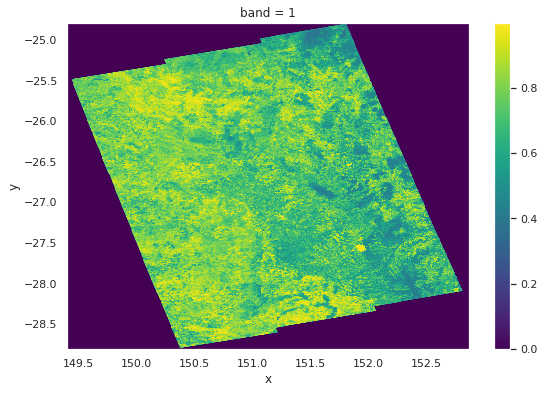

In [17]:
coherence_mean.plot(size=6)

In [20]:
InSAR_no_zeros = InSAR.where(InSAR != 0, np.nan)

In [2]:
InSAR_filt = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/20160324-20160417_HH_8rlks_filt_eqa_cc.tif'))
InSAR_flat = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/20160324-20160417_HH_8rlks_flat_eqa_cc.tif'))

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


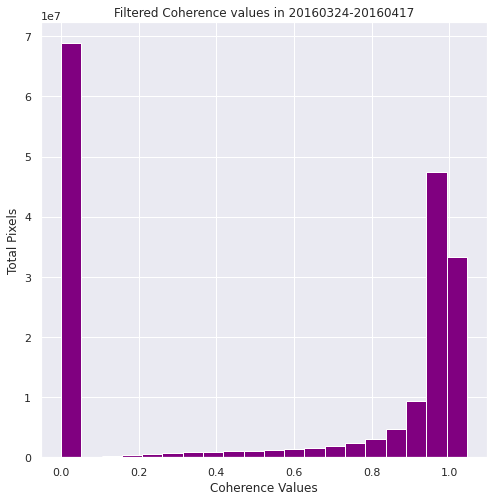

In [7]:
ax = ep.hist(InSAR_filt.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="Filtered Coherence values in 20160324-20160417")

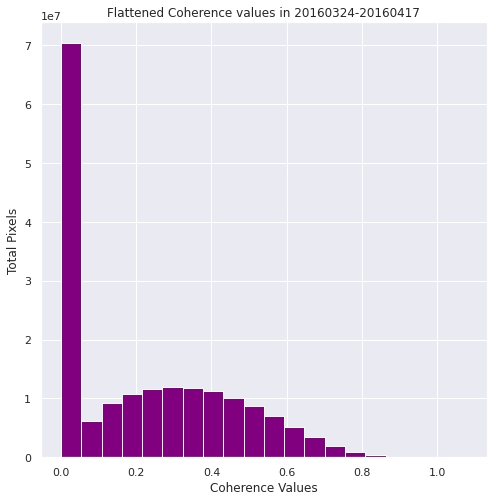

In [8]:
ax = ep.hist(InSAR_flat.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="Flattened Coherence values in 20160324-20160417")

In [28]:
#using multiple coherence files and generate a stack
coh_list = ['..//Real_world_examples/LCCSlayer/20151219-20160112_coh.tif','..//Real_world_examples/LCCSlayer/20151219-20160205_coh.tif','..//Real_world_examples/LCCSlayer/20160112-20160205_coh.tif']
#read the metadata from the first file 
with rasterio.open(coh_list[0]) as src0:
    meta = src0.meta
#update meta to reflect the number of raster files
meta.update(count = len(coh_list))
#Read each layer and write it to the stack
with rasterio.open('..//Real_world_examples/LCCSlayer/stack.tif','w',**meta) as dst:
    for id, layer in enumerate(coh_list,start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id,src1.read(1))

In [37]:
coherence.shape

(3, 965, 832)

In [ ]:
#generate coherence mean and standard deviation 



In [ ]:
#there is a shapefile that you can load and then do the sampling based on the points 
- read the shapefile with points 
- sample the coherence value on each point 

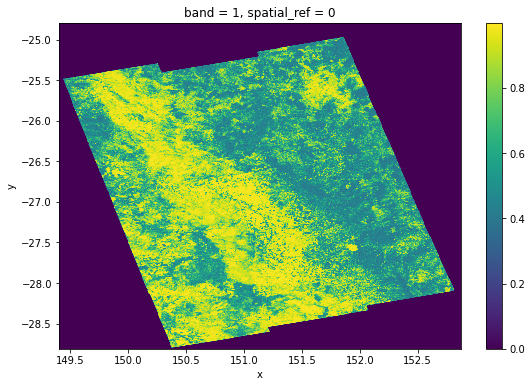

In [6]:
InSAR.plot(size=6)

In [ ]:
#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(data_array, cmap = "viridis")

In [26]:
write_cog(geo_im=LCCS_reprojected,
          fname='..//Real_world_examples/LCCSlayer/lccs_2015_450m.tif',
          overwrite=True)

PosixPath('../Real_world_examples/LCCSlayer/lccs_2015_450m.tif')

In [22]:
InSAR.geobox #width, height in pixel, Affine with spatial resolution and spatial position, and coordinate reference system 

GeoBox(832, 965, Affine(0.004166666700000004, 0.0, 149.40430581111,
       0.0, -0.004166666699999998, -24.79013911111), GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]])

In [24]:
InSAR.geobox.resolution   #InSAR.geobox.extent.boundingbox

(-0.004166666699999998, 0.004166666700000004)

In [26]:
LCCS_coarse = xr_reproject(src=LCCS,
                          geobox=InSAR.geobox,
                          resampling='mode')

In [ ]:
write_cog(LCCS_coarse)

In [51]:
#open the source file and grab metadata from original file 
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif') as src:
    metadata = src.profile
metadata['dtype'] = 'uint8'
metadata['transform'] = src.transform

In [53]:
downscale_factor = 10

In [54]:
#resample LCCS raster file to higher resolution 
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif') as dataset:
        #resample data to target shape
    data = dataset.read(out_shape=(dataset.count,
                                   int(dataset.height*downscale_factor),
                                   int(dataset.width*downscale_factor)),
                        resampling=Resampling.bilinear
    )
    #scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
#     transform[:6]
    metadata['transform'] = tuple(transform[:6])
#     print(tuple(transform))


In [55]:
metadata

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1148, 'height': 1643, 'count': 1, 'crs': CRS.from_epsg(3577), 'transform': (25.0, 0.0, 1727000.0, 0.0, -25.0, -2846250.0), 'tiled': False, 'interleave': 'band'}

In [29]:
print(dataset.shape)x

SyntaxError: invalid syntax (<ipython-input-29-10ed9a93093d>, line 1)

In [13]:
#a numpy array
print(data.shape)

(1, 2957, 2066)


In [56]:
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs-new2.tif','w',**metadata) as dst:
    dst.write(data)

In [15]:
data.metadata

AttributeError: 'numpy.ndarray' object has no attribute 'metadata'

In [175]:
#a numpy array
print(data.shape)

(1, 6572, 4592)


In [122]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint8'}

In [ ]:
#import shapefile of the points that are going to be sampled
#by plotting the point data crs and also your raster make sure that both are in the same coordinate system 
pointData = gpd.read_file('path to the shapefile')
print(pointData.crs)
pointData.plot();

In [ ]:
#Read and open the raster file that needs to be resampled 
#Land cover and Land use file 
LCCRaster = rasterio.open('path to the LCCS file')
print(LCCRaster.crs)
print(LCCRaster.count)
#InSAR coherence file 
# CohRaster = rasterio.open('path to the coherence file')
# print(CohRaster.crs)
# print(CohRaster.count)

In [ ]:
#showing both points and raster file in one plot 
fig, ax = plt.subplot(figsize=(12,12))
pointData.plot(ax=ax, color = 'orangered')
show(LCCRaster,ax=ax)

In [ ]:
#extract point geometry from the point shapefile
for point in pointData['geometry']:
    print(point.xy[0][0],point.xy[1][0])

In [ ]:
#extract raster values in each point location 
for point in pointData['geometry']:
    x = point.xy[0][0]
    y = point.xy[1][0]
    row,col = LCCRaster.index(x,y)
    print('Point corresponds to row,column: %d,%d'%(row,col))
    print('Raster value on point  %.2f \n'%(LCCRaster.read(1)[row,col])) #for single band raster 

In [ ]:
#the reference is here: https://www.youtube.com/watch?v=QhUcgOOsUy8